# Unit commitment problem

This notebook explains how to use the previously introduced algorithms (QAOA, QSVT, QAE, QPA) to solve the unit commitment problem as introduced in https://arxiv.org/abs/2305.08482.\
The unit commitment problem is a combinatorial optimization problem with the objective to decide which generators in a power grid must be turned on, such that all consumers/loads are supplied with sufficient power.\
\
We consider the example system below. The system consists of 5 nodes and 6 transmission lines. \
3 out of 5 nodes are generators (positive power) and the remaining 2 nodes are loads (negative power).

<img src="misc/uc_system.png" width="400"/>

In [1]:
# import python libraries
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from routines.QSVT import qsvt_QSPPACK, plot_poly_QSPPACK, get_precalculated_angles
from routines.bin_dec_conversion import bin2dec, dec2bin, psi2int
from routines.QPA import compute_u_g, qpa

The power grid has the following properties:

In [2]:
# graph
graph = [[0, 1], [0, 2], [1, 3], [2, 3], [2, 4], [3, 4]]

# powers
P1 = 600 # MW
P2 = 400 # MW
P3 = 500 # MW
P4 = -600 # MW
P5 = -900 # MW

# The line susceptances B_ij in the paper are all set to 0.5.
B12 = 0.5
B13 = 0.5
B24 = 0.5
B34 = 0.5
B35 = 0.5
B45 = 0.5
B_ij = [B12, B13, B24, B34, B35, B45]

def get_B(B12, B13, B24, B34, B35, B45):    
    B_avg = (B12+B13+B24+B34+B35+B45)/6
    B_mat = np.array([
        [B12+B13, -B13, -B12, 0, 0],
        [-B13, B13+B34+B35+B_avg, 0, -B34, -B35],
        [-B12, 0, B12+B24, -B24, 0],
        [0, -B24, -B34, B24+B34+B45, -B45],
        [0, -B35, 0, -B45, B35+B45]
    ])
    return B_mat

def pad_mat(mat):
    n = int(np.ceil(np.log2(len(P_vec))))
    new_mat = np.eye(2**n)
    new_mat[:len(mat), :len(mat)] = mat
    return new_mat

def pad_vec(vec):
    n = int(np.ceil(np.log2(len(P_vec))))
    new_vec = np.zeros(2**n)
    new_vec[:len(vec)] = vec
    return new_vec

def normalize_mat(mat):
    normalization = np.linalg.norm(np.matmul(mat, np.transpose(mat)), ord=np.inf)
    return mat/normalization, normalization

def normalize_vec(vec):
    normalization = np.linalg.norm(vec)
    return vec/normalization, normalization

def prepare_A_b(mat, vec):
    mat = pad_mat(mat)
    vec = pad_vec(vec)
    A, s_A = normalize_mat(mat)
    b, s_b = normalize_vec(vec)
    scaling_factor = s_b/s_A

    return A, b, [s_A, s_b, scaling_factor]

# The linear system is built according to Eq.(10) of the reference paper
P_vec = np.array([P1, P2, P3, P4, P5])
B_mat = get_B(B12, B13, B24, B34, B35, B45)

# Prepare linear system for use in QSVT
A, b, scaling_factors = prepare_A_b(B_mat, P_vec)

# Define circuit wires

In [3]:
qaoa_wires = [0, 1, 2]              # QAOA variables
phase_ancilla_wire = [3]            # ancilla qubit required for QPA
phase_wires = [4, 5, 6, 7, 8, 9]    # phase qubits for QAE
ancilla_wires = [10]                # ancilla qubits for QSVT 
block_wire = [11]                   # block qubit for block encoding of A
solution_wires = [12, 13, 14]       # qubits representing the b vector and the solution to Ax=b

# Set up QSVT

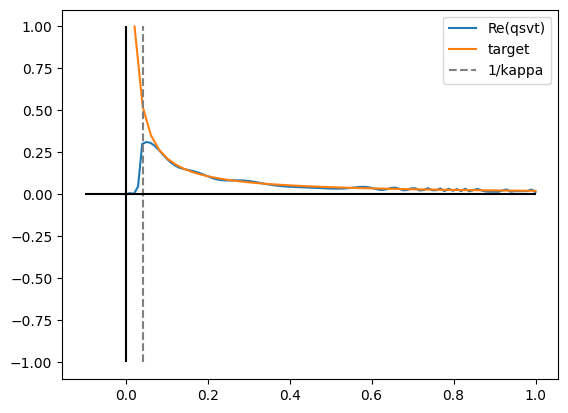

In [4]:
# Initialize phase angles for QSVT
degree = 555
phi_pre = get_precalculated_angles(degree)
plot_poly_QSPPACK(phi_pre, 1/46, 23, degree)

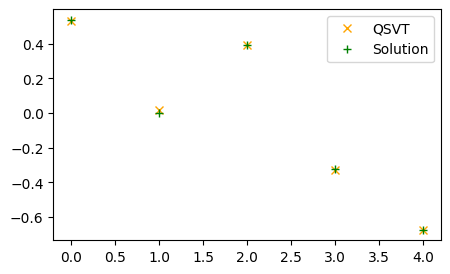

In [5]:
# Check QSVT
wires = ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def solve_ls(A, b):
    qml.StatePrep(b, wires=solution_wires)
    qsvt_QSPPACK(A, phi_pre, wires, degree)

    return qml.state()

qsvt_state = solve_ls(A, b)[:len(P_vec)].real
x_expected = np.linalg.solve(B_mat, P_vec)

plt.figure(figsize=(5, 3))
plt.plot(qsvt_state/np.linalg.norm(qsvt_state), marker='x', c='orange', label="QSVT", ls="")
plt.plot(x_expected/np.linalg.norm(x_expected), marker='+', c='green', label="Solution", ls="")
plt.legend()
plt.show()

In [6]:
# define QSVT operator with controls on QAOA register
class qsvt_qaoa(qml.operation.Operation):
    def __init__(self, A, b, phi, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires, id=None):
        super().__init__(wires=qaoa_wires+ancilla_wires+block_wire+solution_wires, id=id)
        self.A = A
        self.b = b
        self.phi = phi
        self.degree = degree
        self.qaoa_wires = qaoa_wires
        self.ancilla_wires = ancilla_wires
        self.block_wire = block_wire
        self.solution_wires = solution_wires

    def decomposition(self):
        # We want to prepare the b state (of Ax=b) and depending on the QAOA variables, some amplitudes are set to zero. 
        # e.g. b[0] = 0 if qaoa_qubit[0] == 0 
        # Here, we switch b[0] with b[5], b[1] with b[6], and b[2] with b[7] to get the same normalization constant of the entire b state.
        U_16 = np.array([
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
            ])
        U_27 = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
            ])
        U_38 = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            ])
        ops = []
        ops.append(qml.StatePrep(self.b, wires=self.solution_wires))
        ops.append(qml.ctrl(qml.QubitUnitary(U_16, wires=self.solution_wires), control=self.qaoa_wires[0], control_values=(0,)))
        ops.append(qml.ctrl(qml.QubitUnitary(U_27, wires=self.solution_wires), control=self.qaoa_wires[1], control_values=(0,)))
        ops.append(qml.ctrl(qml.QubitUnitary(U_38, wires=self.solution_wires), control=self.qaoa_wires[2], control_values=(0,)))
        ops.append(qsvt_QSPPACK(self.A, self.phi, self.ancilla_wires + self.block_wire + self.solution_wires, self.degree))

        return ops

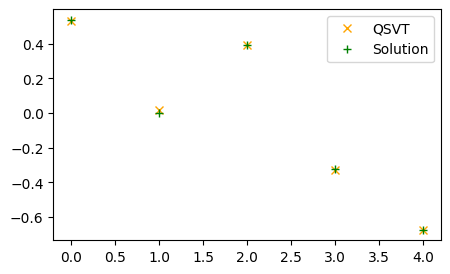

In [7]:
# check QSVT with QAOA
wires = qaoa_wires + ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def solve_ls_qaoa(qaoa_vars, A, b):
    for i, var in enumerate(qaoa_vars):
        if var == 1:
            qml.PauliX(wires=qaoa_wires[i])
    qsvt_qaoa(A, b, phi_pre, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires)

    return qml.state()

qaoa_vars = [1, 1, 1]
P_vec_modified = P_vec.copy()
for i, var in enumerate(qaoa_vars):
    if var == 0:
        P_vec_modified[i] = 0
qsvt_state = solve_ls_qaoa(qaoa_vars, A, b).real
# get rid of qaoa_wires
qsvt_state = np.transpose(qsvt_state.reshape((2**len(qaoa_wires), -1)))
qsvt_state = [float(np.sum(el)) for el in qsvt_state][:len(P_vec)]
qsvt_state /= np.linalg.norm(qsvt_state)
x_expected = np.linalg.solve(B_mat, P_vec_modified)

plt.figure(figsize=(5, 3))
plt.plot(qsvt_state/np.linalg.norm(qsvt_state), marker='x', c='orange', label="QSVT", ls="")
plt.plot(x_expected/np.linalg.norm(x_expected), marker='+', c='green', label="Solution", ls="")
# plt.plot(P_vec_modified/np.linalg.norm(P_vec_modified), marker='+', c='red', label="b", ls="")
plt.legend()
plt.show()

# Get phase difference

After solving the linear system, we get a solution containing all phases (of the electric current) as $\ket{x}=\sum_i \theta_i\ket{i}$. However, we are interested in the phase differences between two nodes $i$ and $j$. That's why we need a quantum circuit for $\sum_i \theta_i\ket{i}\mapsto C(\theta_i-\theta_j)\ket{0} + \dots$, where $C$ ensures normalization. Check out the paper on arXiv for more details.

In [8]:
# define phase_diff operator
class phase_diff(qml.operation.Operation):
    def __init__(self, i, j, wires, id=None):
        super().__init__(wires=wires, id=id)
        self.i = i
        self.j = j

    def decomposition(self):
        ops = []
        def get_bit(number, index, bit_width):
            # Calculate the position of the bit in little-endian convention
            little_endian_index = bit_width - 1 - index
            return (number >> little_endian_index) & 1

        bit_width = len(self.wires)
        
        # move the i state to the 0 state
        for k in range(bit_width):
            if get_bit(self.i, k, bit_width) == 1:
                ops.append(qml.PauliX(wires=self.wires[k]))
        
        # get the 1st index for which j^i is not 0
        j_updated = self.j ^ self.i
        highest_nonzero_bit = int(np.log2(j_updated & ((~j_updated) + 1)))
        highest_nonzero_bit_big_endian = bit_width - 1 - highest_nonzero_bit

        # flip all 1 bits in updated j conditioned on the 1st bit
        for k in range(bit_width):
            if k != highest_nonzero_bit_big_endian and get_bit(j_updated, k, bit_width):
                ops.append(qml.CNOT(wires=[self.wires[highest_nonzero_bit_big_endian], self.wires[k]]))

        # apply H and X on highest_nonzero_bit
        ops.append(qml.Hadamard(wires=self.wires[highest_nonzero_bit_big_endian]))
        ops.append(qml.PauliX(wires=self.wires[highest_nonzero_bit_big_endian]))

        return ops

In [9]:
# check phase_diff
phase_vec = np.array([3, 5, 2, 1, 9, 5, 3, 8])*(1+2j)
phase_vec = phase_vec/np.linalg.norm(phase_vec)

dev = qml.device("default.qubit", wires=[0, 1, 2])
@qml.qnode(dev)
def test_phase_diff(i, j, phase_vec):
    qml.StatePrep(phase_vec, wires=[0, 1, 2])
    phase_diff(i, j, [0, 1, 2])

    return qml.state()

i = 3
j = 4

phase_diff_state = test_phase_diff(i, j, phase_vec)
extracted_phase_diff = phase_diff_state[0]*np.sqrt(2)
expected_phase_diff = phase_vec[i]-phase_vec[j]
print(f"QC: {extracted_phase_diff}, Expected: {expected_phase_diff}")

QC: (-0.2423130131261531-0.4846260262523062j), Expected: (-0.24231301312615308-0.48462602625230616j)


# Combine QSVT and phase difference

In [10]:
# define qsvt_phase_diff operator
class qsvt_qaoa_phase_diff(qml.operation.Operation):
    def __init__(self, i, j, A, b, phi, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires, id=None):
        super().__init__(wires=qaoa_wires+ancilla_wires+block_wire+solution_wires, id=id)
        self.i = i
        self.j = j
        self.A = A
        self.b = b
        self.phi = phi
        self.degree = degree
        self.qaoa_wires = qaoa_wires
        self.ancilla_wires = ancilla_wires
        self.block_wire = block_wire
        self.solution_wires = solution_wires

    def decomposition(self):
        ops = []
        ops.append(qsvt_qaoa(self.A, self.b, self.phi, self.degree, self.qaoa_wires, self.ancilla_wires, self.block_wire, self.solution_wires))
        ops.append(phase_diff(self.i, self.j, solution_wires))
        return ops

In [11]:
# check QSVT with QAOA and phase difference
wires = qaoa_wires + ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def test_qsvt_qaoa_phase_diff(i, j, qaoa_vars, A, b):
    for i, var in enumerate(qaoa_vars):
        if var == 1:
            qml.PauliX(wires=qaoa_wires[i])
    qsvt_qaoa_phase_diff(i, j, A, b, phi_pre, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires)

    return qml.state()

i = 0
j = 4

qaoa_vars = [1, 1, 1]
P_vec_modified = P_vec.copy()
for i, var in enumerate(qaoa_vars):
    if var == 0:
        P_vec_modified[i] = 0
qsvt_state = test_qsvt_qaoa_phase_diff(i, j, qaoa_vars, A, b)
# get rid of qaoa_wires
qsvt_state = np.transpose(qsvt_state.reshape((2**len(qaoa_wires), -1)))
qsvt_state = [np.sum(el) for el in qsvt_state][:len(P_vec)]

qsvt_phase_diff_value = qsvt_state[0]*np.sqrt(2) # 1/sqrt(2) is the normalization constant


# Run QSVT with QAOA and without phase_difference
dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def test_qsvt_qaoa(qaoa_vars, A, b):
    for i, var in enumerate(qaoa_vars):
        if var == 1:
            qml.PauliX(wires=qaoa_wires[i])
    qsvt_qaoa(A, b, phi_pre, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires)

    return qml.state()

qaoa_vars = [1, 1, 1]
P_vec_modified = P_vec.copy()
for i, var in enumerate(qaoa_vars):
    if var == 0:
        P_vec_modified[i] = 0
qsvt_state = test_qsvt_qaoa(qaoa_vars, A, b)
# get rid of qaoa_wires
qsvt_state = np.transpose(qsvt_state.reshape((2**len(qaoa_wires), -1)))
qsvt_state = [np.sum(el) for el in qsvt_state][:len(P_vec)]

expected_phase_diff_value = qsvt_state[i]-qsvt_state[j]

print(qsvt_phase_diff_value, expected_phase_diff_value)

(0.2567076842384699+0.2796198110070426j) (0.2567076842384699+0.27961981100704264j)


# Set up QAE
$Q = -AS_0A^\dagger S_\psi$

In [12]:
# define Grover operator
def grover_op_list(i, j, A, b, phi, degree, psi, qaoa_wires, ancilla_wires, block_wire, solution_wires):
    ops = []
    ops.append(qml.FlipSign([0]*len(ancilla_wires) + [0]*len(block_wire) + psi, wires=ancilla_wires+block_wire+solution_wires))         # S_psi
    ops.append(qml.adjoint(qsvt_qaoa_phase_diff)(i, j, A, b, phi, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires))   # A^dagger
    ops.append(qml.FlipSign([0]*len(ancilla_wires) + [0]*len(block_wire) + [0, 0, 0], wires=ancilla_wires+block_wire+solution_wires))   # S_0
    ops.append(qsvt_qaoa_phase_diff(i, j, A, b, phi, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires))                # A
    ops.append(qml.GlobalPhase(np.pi, wires=ancilla_wires+block_wire+solution_wires))                                                   # -1

    return ops

class grover_operator(qml.operation.Operation):
    def __init__(self, i, j, A, b, phi, degree, psi, qaoa_wires, ancilla_wires, block_wire, solution_wires, id=None):
        super().__init__(wires=ancilla_wires+block_wire+solution_wires, id=id)
        self.i = i
        self.j = j
        self.A = A
        self.b = b
        self.phi = phi
        self.degree = degree
        self.psi = psi
        self.qaoa_wires = qaoa_wires
        self.ancilla_wires = ancilla_wires
        self.block_wire = block_wire
        self.solution_wires = solution_wires

    def decomposition(self):
        # Define the sequence of operations that make up the custom operation
        return grover_op_list(self.i, self.j, self.A, self.b, self.phi, self.degree, self.psi, self.qaoa_wires, self.ancilla_wires, self.block_wire, self.solution_wires)

In [13]:
# define QAE operator
def qae_op_list(i, j, A, b, phi, degree, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi=[0, 0, 0]):
    ops = []
    ops.append(qsvt_qaoa_phase_diff(i, j, A, b, phi, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires)) # prepare phase difference
    for wire in phase_wires:
        ops.append(qml.Hadamard(wires=wire))    # apply Hadamard gates on phase register
    ops.append(qml.ControlledSequence(grover_operator(i, j, A, b, phi, degree, psi, qaoa_wires, ancilla_wires, block_wire, solution_wires), control=phase_wires))   # apply controlled sequence of Grover operators (containing qsvt)
    ops.append(qml.adjoint(qml.QFT)(wires=phase_wires)) # apply Inverse Fourier Transform on phase register

    return ops

class qae(qml.operation.Operation):
    def __init__(self, i, j, A, b, phi, degree, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi=[0, 0, 0], id=None):
        super().__init__(wires=phase_wires+ancilla_wires+block_wire+solution_wires, id=id)
        self.i = i
        self.j = j
        self.A = A
        self.b = b
        self.phi = phi
        self.degree = degree
        self.psi = psi
        self.qaoa_wires = qaoa_wires
        self.phase_wires = phase_wires
        self.ancilla_wires = ancilla_wires
        self.block_wire = block_wire
        self.solution_wires = solution_wires

    def decomposition(self):
        # Define the sequence of operations that make up the custom operation
        return qae_op_list(self.i, self.j, self.A, self.b, self.phi, self.degree, self.qaoa_wires, self.phase_wires, self.ancilla_wires, self.block_wire, self.solution_wires, self.psi)

QAE result: 0.14673047445536175 (0.000011)
QSVT amplitude: 0.16861792698522746 (0.0000110111 or 0.1111001000)


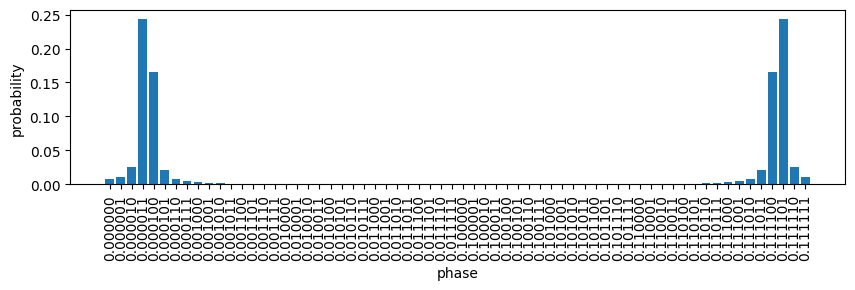

In [14]:
# check QAE with Grover operator
def qae_circuit(i, j, A, b, phi, degree, qaoa_vars, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi=[0, 0, 0]):
    # initialize qaoa configuration
    for i, var in enumerate(qaoa_vars):
        if var == 1:
            qml.PauliX(wires=qaoa_wires[i])
    # call QAE operator
    qae(i, j, A, b, phi, degree, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi)

i = 0
j = 1
psi = [0, 0, 0]
qaoa_vars = [1, 1, 1]
wires = qaoa_wires+phase_wires+ancilla_wires+block_wire+solution_wires
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def test_qae(i, j, A, b, psi):
    qae_circuit(i, j, A, b, phi_pre, degree, qaoa_vars, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi)
    return qml.probs(wires=phase_wires)

results = test_qae(i, j, A, b, psi)
bit_strings = [f"0.{x:0{len(phase_wires)}b}" for x in range(len(results))]

plt.figure(figsize=(10, 3))
plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
print(f"QAE result: {np.sin(bin2dec(bit_strings[results.tolist().index(max(results))])*np.pi)} ({bit_strings[results.tolist().index(max(results))]})")

# expected result
wires = qaoa_wires + ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def test_qsvt_qaoa_phase_diff(i, j, qaoa_vars, A, b):
    for i, var in enumerate(qaoa_vars):
        if var == 1:
            qml.PauliX(wires=qaoa_wires[i])
    qsvt_qaoa_phase_diff(i, j, A, b, phi_pre, degree, qaoa_wires, ancilla_wires, block_wire, solution_wires)

    return qml.state()
qsvt_state = test_qsvt_qaoa_phase_diff(i, j, qaoa_vars, A, b)
# get rid of qaoa_wires
qsvt_state = np.transpose(qsvt_state.reshape((2**len(qaoa_wires), -1)))
qsvt_state = [np.sum(el) for el in qsvt_state][:len(P_vec)]

# qsvt_phase_diff_value = qsvt_state[0]*np.sqrt(2) # 1/sqrt(2) is the normalization constant
magnitude = abs(qsvt_state[psi2int(psi)])
print(f"QSVT amplitude: {magnitude} ({dec2bin(np.arcsin(magnitude)/np.pi)} or {dec2bin(1+np.arcsin(-magnitude)/np.pi)})")

# Set up QPA

First we need a unitary $U_g$ that computes $g(x)=\sin(x\pi)$ to extract the amplitude from the phase register of the QAE routine. $U_g$ is realized here with a block encoded matrix containing the specific mapping between bitstrings.

In [15]:
# Define U_g operator
U_g_matrix = compute_u_g(len(phase_wires))

class U_g(qml.operation.Operation):
    def __init__(self, U_g_matrix, phase_ancilla_wire, phase_wires, id=None):
        super().__init__(wires=phase_ancilla_wire+phase_wires, id=id)
        self.U_g_matrix = U_g_matrix

    def decomposition(self):
        # Define the sequence of operations that make up the custom operation
        return [qml.BlockEncode(self.U_g_matrix, wires=self.wires)]

The unitary operation $U_g$ in combination with a controlled QPA circuit results in effective phase application (see figure below).

<img src="misc/QPA_circuit.png" width="400"/>

In [16]:
def qpa_circuit(gamma, phase_ancilla_wire, phase_wires):
    U_g(U_g_matrix, phase_ancilla_wire, phase_wires)
    qml.ctrl(qpa(gamma, phase_wires, twos_complement=True), control=phase_ancilla_wire, control_values=(0,)) # Here we use two's complement to represent negative numbers as well

# Set up QAOA
Now it is time to use all building blocks to define our QAOA algorithm. Therefore, we start with building the QAOA cost layer:

In [17]:
def U_C(gamma):
    # for every connection in our graph, we need to add the cost 
    for i, j in graph:
        qae(i, j, A, b, phi_pre, degree, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi=[0, 0, 0])
        # Since we always ensured correct normalization, we would need to rescale the extracted cost by a constant factor. This can be achieved by adjusting gamma, which we have neglected here.
        qpa_circuit(gamma, phase_ancilla_wire, phase_wires)
        # Uncomputation
        qml.adjoint(U_g(U_g_matrix, phase_ancilla_wire, phase_wires))
        qml.adjoint(qae(i, j, A, b, phi_pre, degree, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi=[0, 0, 0]))

        # In the unit commit problem, there are other cost Hamiltonians that can be added here as well.

Next, we assemble the mixer layer:

In [18]:
H_M = -1 * qml.PauliX(wires=0)
for wire in range(1, len(qaoa_wires)):
    H_M -= qml.PauliX(wires=wire)
def U_M(beta):
    qml.qaoa.mixer_layer(beta, H_M)

Let's define the QAOA circuit:

In [19]:
depth = 1
wires = qaoa_wires+phase_ancilla_wire+phase_wires+ancilla_wires+block_wire+solution_wires

# define a single qaoa layer
def qaoa_layer(gamma, beta):
    U_C(gamma)
    U_M(beta)

# define the qaoa circuit
def qaoa_circuit(params):
    # Initialize ground state of mixer Hamiltonian
    for wire in wires:
        qml.Hadamard(wires=wire)
    # Apply qaoa layers
    qml.layer(qaoa_layer, depth, params[0], params[1])

Finally, we have to define the cost function:

In [20]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function_ij(i, j, params):
    qaoa_circuit(params)
    # Since we have no cost Hamiltonian, we extract the cost using our QAE routine
    qae(i, j, A, b, phi_pre, degree, qaoa_wires, phase_wires, ancilla_wires, block_wire, solution_wires, psi=[0, 0, 0])
    U_g(U_g_matrix, phase_ancilla_wire, phase_wires)    # get the amplitude from QAE phase
    m0 = qml.measure(wires=phase_ancilla_wire, postselect=0)    # post selection measurement to ensure correct application of U_g

    return qml.probs(wires=phase_wires) # measure phase wires to extract cost

# get the bitstring of the state with highest probability
def max_prob_bitstring(probabilities):
    max_index = max(range(len(probabilities)), key=probabilities.__getitem__)
    bit_length = len(probabilities).bit_length() - 1
    fractional_part = f'{max_index:0{bit_length}b}'
    return '0.' + fractional_part

def cost_function(params):
    total_cost = 0
    for i, j in graph:
        probs = cost_function_ij(i, j, params)
        cost = bin2dec(max_prob_bitstring(probs), twos_complement=True) # As previously mentioned, this is the cost up to some constant scaling factor.
        total_cost += cost
    
    return total_cost


We could try to optimize the cost function as follows:

In [21]:
optimizer = qml.GradientDescentOptimizer()
steps = 5
params = np.array([[0.5]*depth, [0.5]*depth], requires_grad=True)
cost_list = []

initial = True

## For your safety, we have commented out the code.
# for step in range(steps):
#     params, cost = optimizer.step_and_cost(cost_function, params)
#     cost_list.append(cost)
#     if initial:
#         print(f"Initial cost: {cost}")
#         initial = False
#     print(f"Cost at step {step}: {cost}", end="\r")
# plt.figure(figsize=(7, 4))
# plt.plot(cost_list)
# plt.ylabel("Cost")
# plt.xlabel("Iteration")
# plt.show()

To run the optimization, we would require a lot of memory. 
Unfortunately, the circuit becomes very large, as we need many phase qubits for high precision and a high order polynomial to approximate 1/x for high condition numbers. Nonetheless, we want to show you that QAOA is able to optimze this problem by defining the cost Hamiltonian by hand. Therefore, we can write the cost terms in the diagonal of the Hamiltonian and try the algorithm again:

In [22]:
import itertools
# Create all possible configurations in natural order
bitstrings = [''.join(bits) for bits in itertools.product('01', repeat=len(qaoa_wires))]

C_L = 1 # cost of transmission per unit time per unit of power

# Calculate the corrsponding costs
costs = []
for bitstring in bitstrings:
    cost = 0
    P_vec_modified = P_vec.copy()
    for i, bit in enumerate(bitstring):
        if bit == '0':
            P_vec_modified[i] = 0
    electric_phases = np.linalg.solve(B_mat, P_vec_modified)
    for k, (i, j) in enumerate(graph):
        cost += C_L*B_ij[k]*(electric_phases[i]-electric_phases[j])
    costs.append(float(cost))

# Define cost Hamiltonian
H_C = qml.pauli_decompose(np.diag(costs))

# Redefine cost layer

In [23]:
def U_C(gamma):
    qml.qaoa.cost_layer(gamma, H_C)

# Set up simple QAOA

In [24]:
depth = 3
wires = qaoa_wires

# define a single qaoa layer
def qaoa_layer(gamma, beta):
    U_C(gamma)
    U_M(beta)

# define the qaoa circuit
def qaoa_circuit(params):
    # Initialize ground state of mixer Hamiltonian
    for wire in wires:
        qml.Hadamard(wires=wire)
    # Apply qaoa layers
    qml.layer(qaoa_layer, depth, params[0], params[1])

# define cost function
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    qaoa_circuit(params)
    return qml.expval(H_C)

# Optimize ...

Initial cost: 1827.25911152917


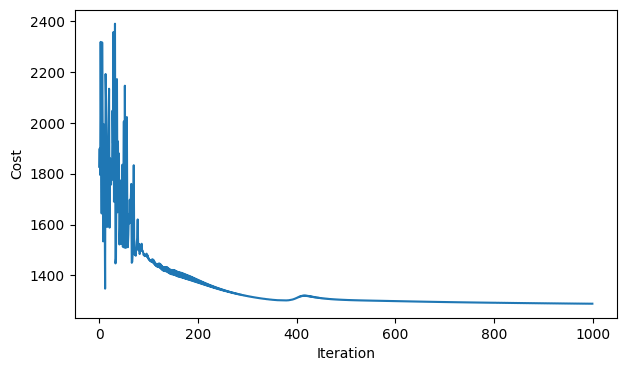

In [25]:
optimizer = qml.AdagradOptimizer()
steps = 1000
params = np.array([[0.5]*depth, [0.5]*depth], requires_grad=True)
cost_list = []

initial = True

# start optimization
for step in range(steps):
    params, cost = optimizer.step_and_cost(cost_function, params)
    cost_list.append(cost)
    if initial:
        print(f"Initial cost: {cost}")
        initial = False
    print(f"Cost at step {step}: {cost}", end="\r")
plt.figure(figsize=(7, 4))
plt.plot(cost_list)
plt.ylabel("Cost")
plt.xlabel("Iteration")
plt.show()

As you can see, the cost landscape is rough but the optimizer manages to converge to a solution with low cost.

In [26]:
@qml.qnode(dev)
def probability_circuit(gamma, beta):
    qaoa_circuit([gamma, beta])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

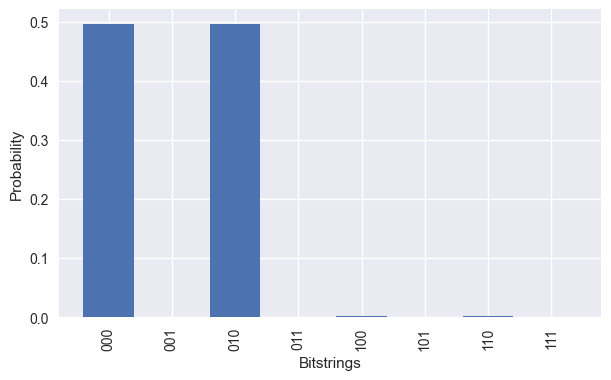

In [27]:
num_qubits = len(qaoa_wires)
bitstrings = [''.join(seq) for seq in itertools.product('01', repeat=num_qubits)]

plt.figure(figsize=(7, 4))
plt.style.use('seaborn-v0_8')
plt.bar(range(2 ** num_qubits), probs)
plt.ylabel("Probability")
plt.xlabel("Bitstrings")
plt.xticks(ticks=range(2 ** num_qubits), labels=bitstrings, rotation=90)  # Add bitstrings as x labels
plt.show()

Looking at the probability distribution, QAOA reliably finds the two configurations with the lowest cost.

In [28]:
print(f"Minimal cost: {min(costs)}, cost of 000: {costs[0]}, cost of 010: {costs[2]}")

Minimal cost: 1281.818181818181, cost of 000: 1281.818181818181, cost of 010: 1281.8181818181813
